In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Data/BC/mackenzie1972-2023.csv')

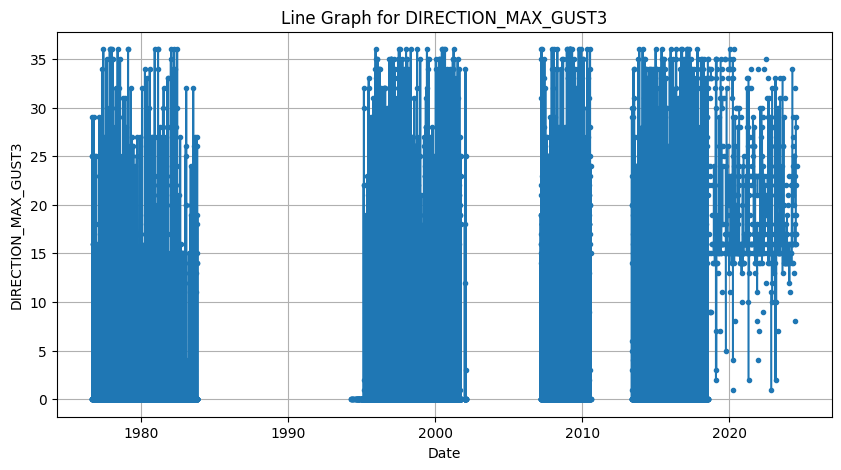

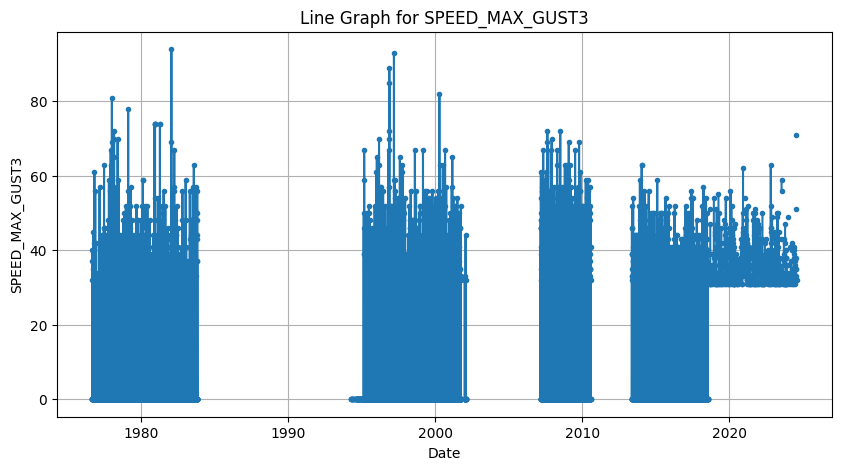

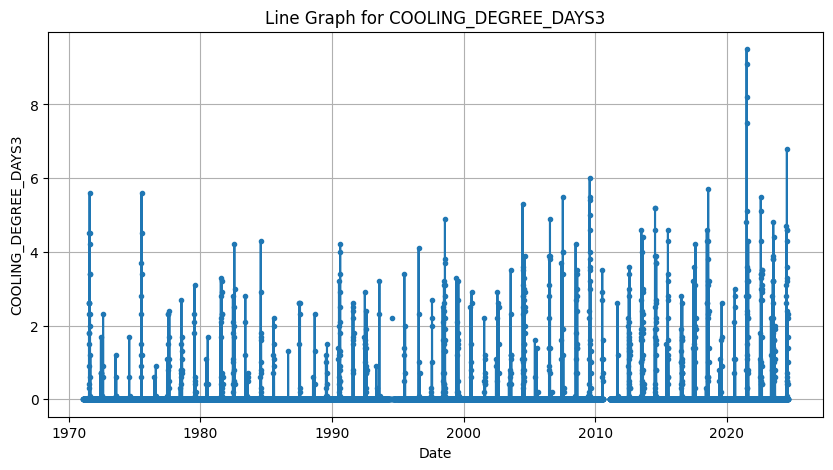

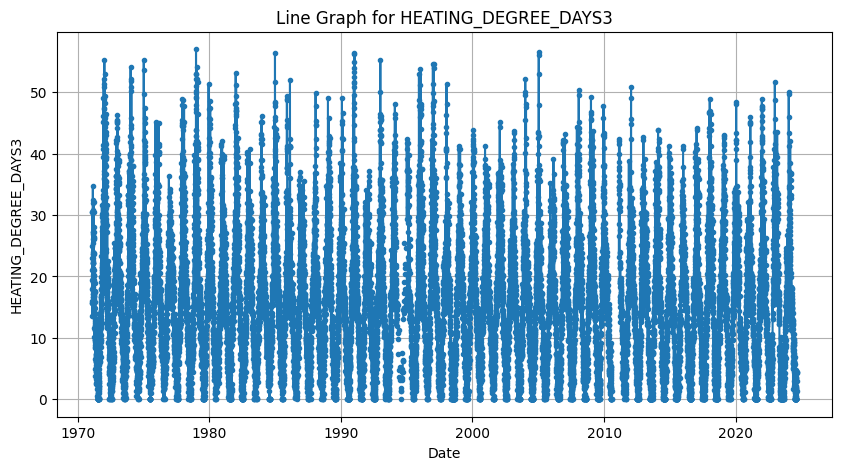

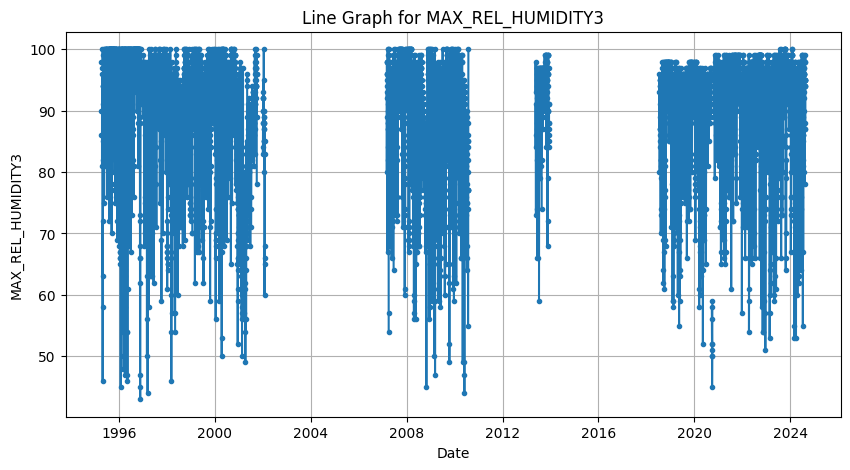

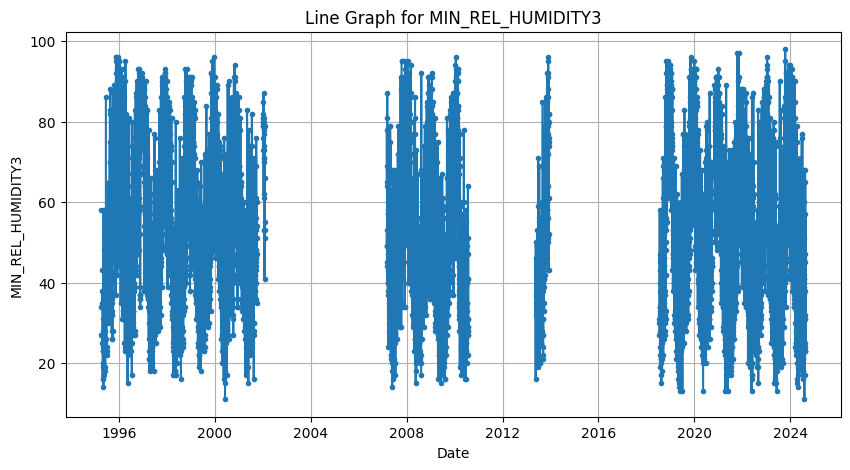

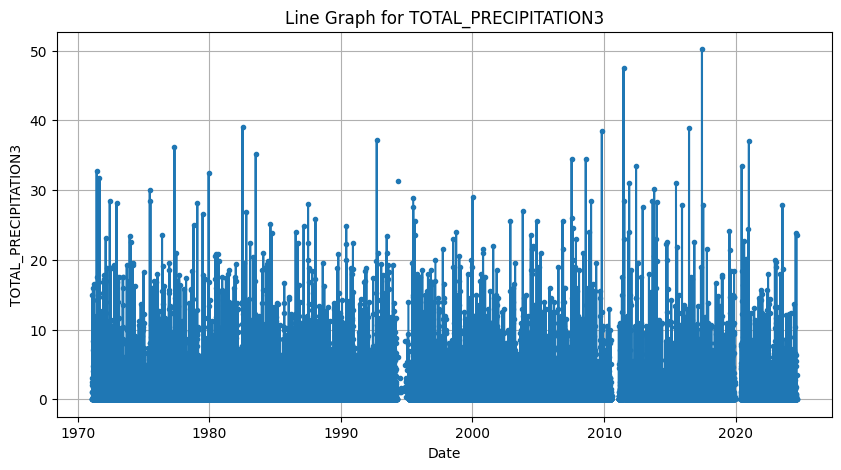

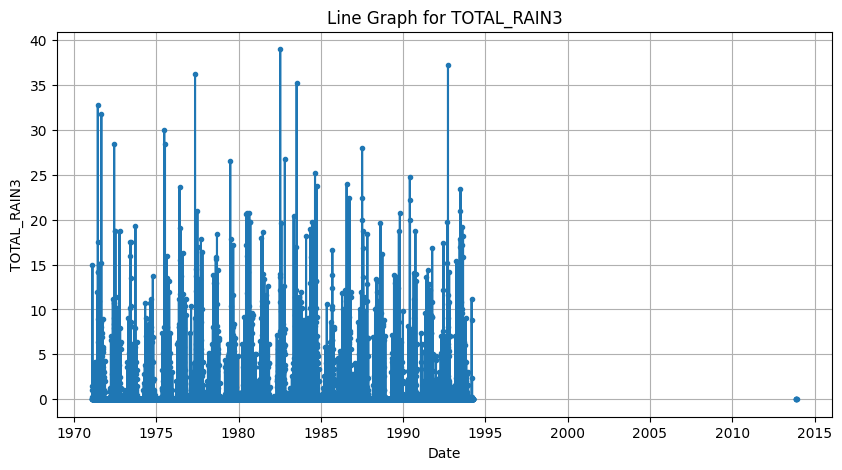

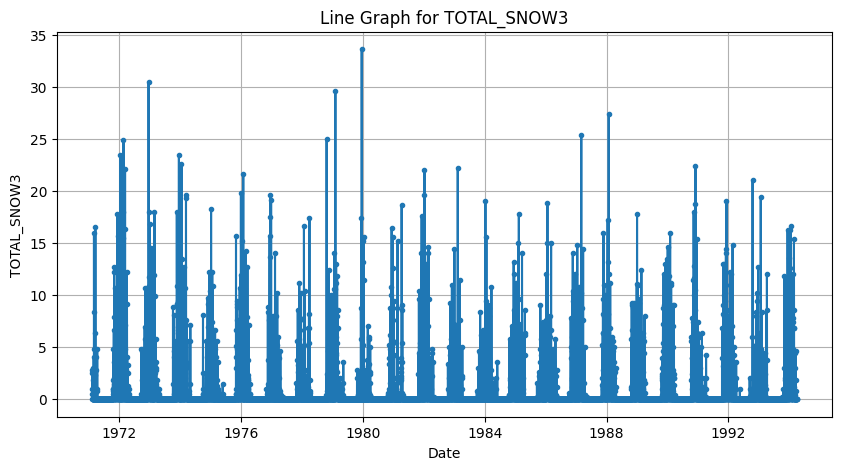

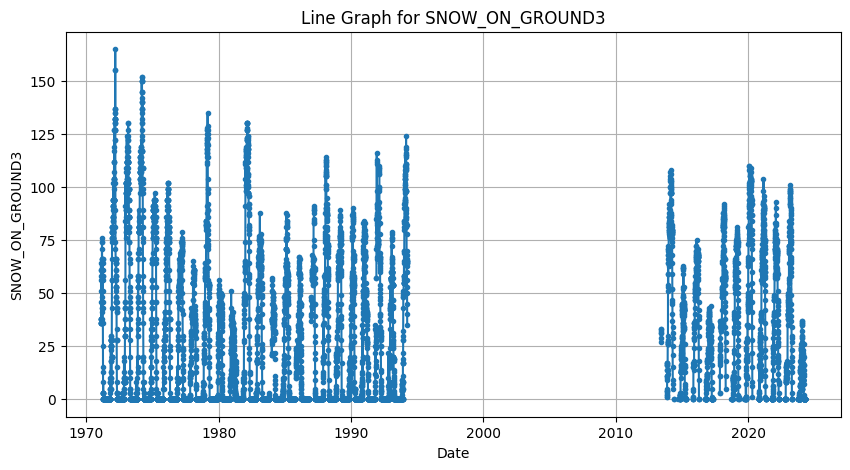

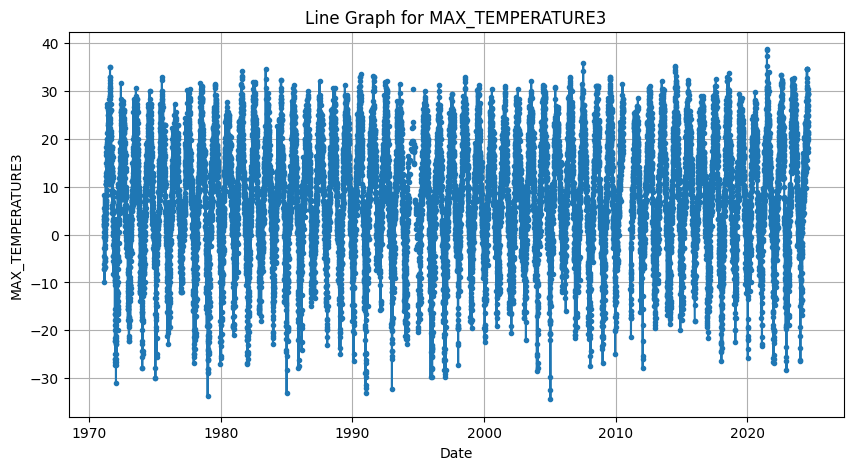

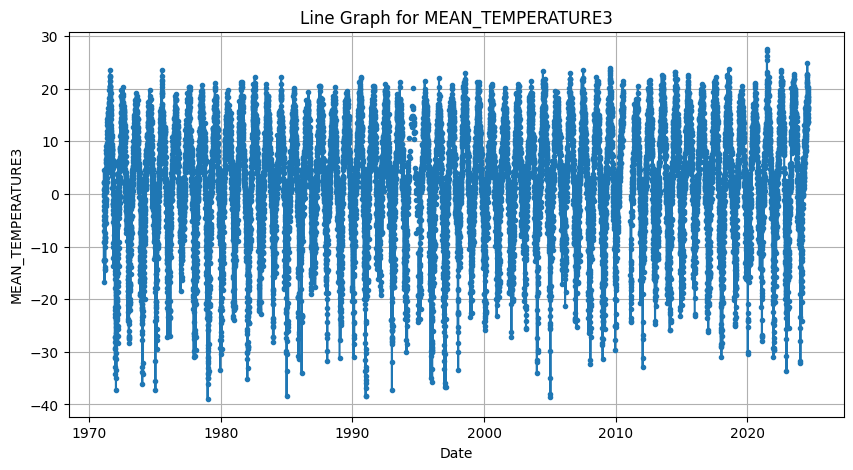

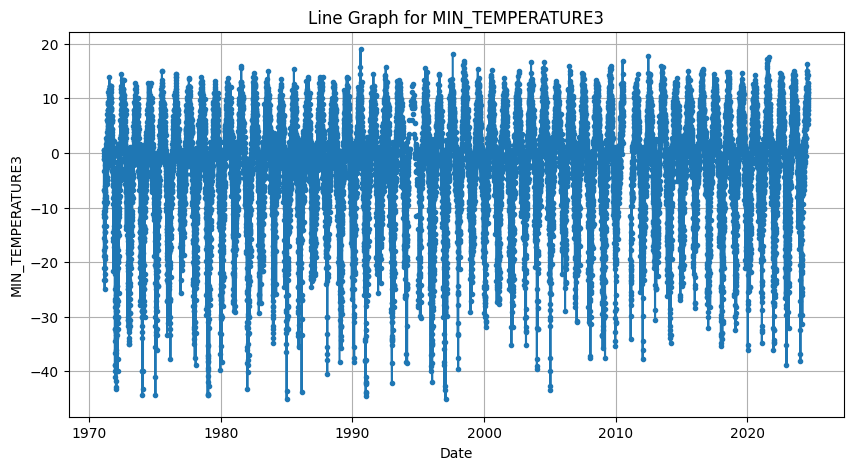

In [5]:
df['LOCAL_DATE3'] = pd.to_datetime(df['LOCAL_DATE3'])
df.set_index('LOCAL_DATE3', inplace=True)

columns_to_plot = df.iloc[:, :]

# Loop through each selected column and plot it
for column in columns_to_plot.columns:
    if pd.api.types.is_numeric_dtype(columns_to_plot[column]):
        plt.figure(figsize=(10, 5))  # Set the figure size
        plt.plot(df.index, columns_to_plot[column], marker='.')  # Plot each column as a line graph
        plt.title(f'Line Graph for {column}')  # Title with the column name
        plt.xlabel('Date')  # Label for the x-axis
        plt.ylabel(column)  # Label for the y-axis
        plt.grid(True)  # Add a grid for better readability
        plt.show()  # Display the plot
    else:
        print(f"Skipping column {column} as it is not numeric.")

df = pd.read_csv('Data/BC/interpolated_file7.csv')
df['LOCAL_DATE'] = pd.to_datetime(df['LOCAL_DATE'])
df['Year'] = df['LOCAL_DATE'].dt.year
df['Month'] = df['LOCAL_DATE'].dt.month
df['Day'] = df['LOCAL_DATE'].dt.day
print(df.head())
print(df.describe())

# Best to keep these for interpol, not Humid cuz that has a massive gap of missing vals
df['TOTAL_PRECIPITATION'] = df['TOTAL_PRECIPITATION'].interpolate(method='linear')
df['HEATING_DEGREE_DAYS'] = df['HEATING_DEGREE_DAYS'].interpolate(method='linear')
df['COOLING_DEGREE_DAYS'] = df['COOLING_DEGREE_DAYS'].interpolate(method='linear')
df['MAX_TEMPERATURE'] = df['MAX_TEMPERATURE'].interpolate(method='linear')
df['MEAN_TEMPERATURE'] = df['MEAN_TEMPERATURE'].interpolate(method='linear')
df['MIN_TEMPERATURE'] = df['MIN_TEMPERATURE'].interpolate(method='linear')

df.to_csv('interpolated_file8.csv', index=False)
df = pd.read_csv('Data/BC/interpolated_file8.csv')
print(df.head())

columns_to_replace = ['SPEED_MAX_GUST', 'DIRECTION_MAX_GUST']
df[columns_to_replace] = df[columns_to_replace].replace(0, np.nan)
df.to_csv('interpolated_file9.csv', index=False)
df = pd.read_csv('Data/BC/interpolated_file9.csv')
print(df.head())

In [29]:
df = pd.read_csv('Data/BC/interpolated_file9.csv')
df['LOCAL_DATE'] = pd.to_datetime(df['LOCAL_DATE'])

# Labels are the values we want to predict
labels = np.array(df['Value'])
# Remove the labels from the df
# axis 1 refers to the columns
df = df.drop(columns=['Value', 'PARAM', 'SYM', 'LOCAL_DATE'])
# Saving feature names for later use
feature_list = list(df.columns)
# Convert to numpy array
df = np.array(df)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(df, labels, test_size = 0.20, random_state = 5)

In [30]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (8701, 14)
Training Labels Shape: (8701,)
Testing Features Shape: (2176, 14)
Testing Labels Shape: (2176,)


In [31]:

# Baseline errors, and display average baseline error
baseline_errors = abs(88.292578 - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  79.64


In [32]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 300, random_state = 22)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=300, random_state=22)

In [33]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'm3/s.')

Mean Absolute Error: 16.73 m3/s.


In [34]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 80.77 %.


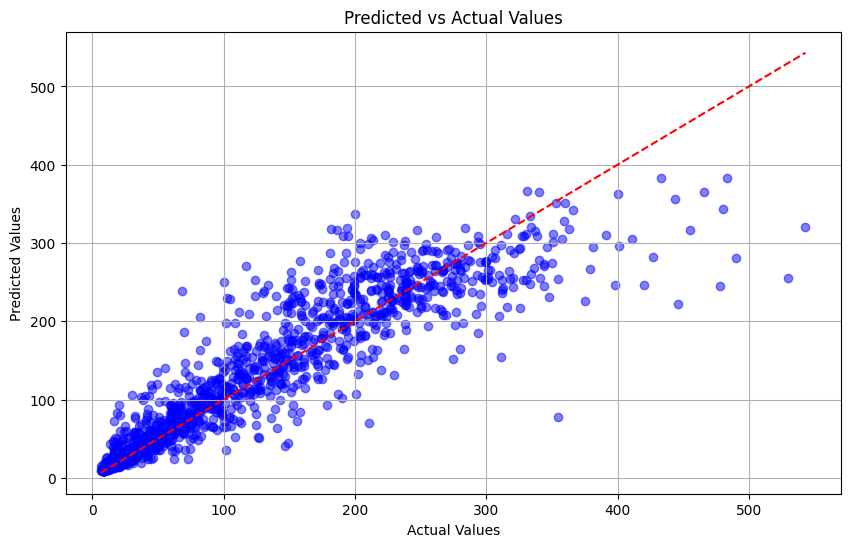

In [35]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, color='blue', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], color='red', linestyle='--')  # Diagonal line
plt.grid(True)
plt.show()

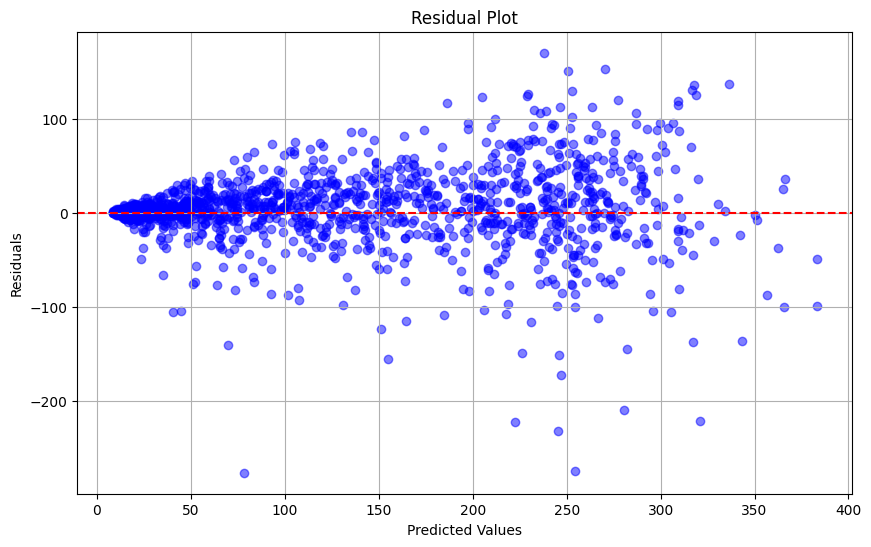

In [36]:
# Calculate residuals
residuals = predictions - test_labels
# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

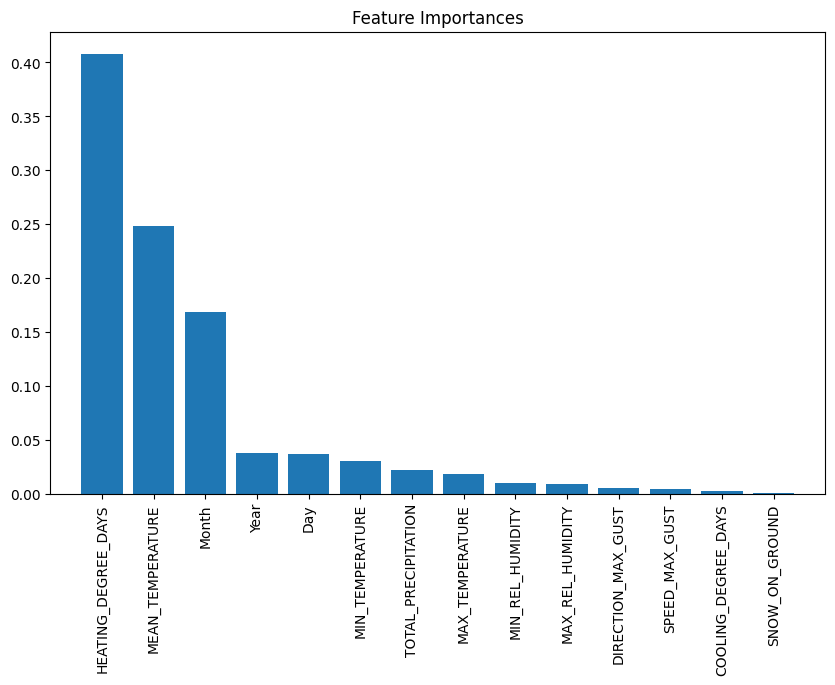

In [37]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(train_features.shape[1]), importances[indices], align='center')
plt.xticks(range(train_features.shape[1]), np.array(feature_list)[indices], rotation=90)
plt.xlim([-1, train_features.shape[1]])
plt.show()

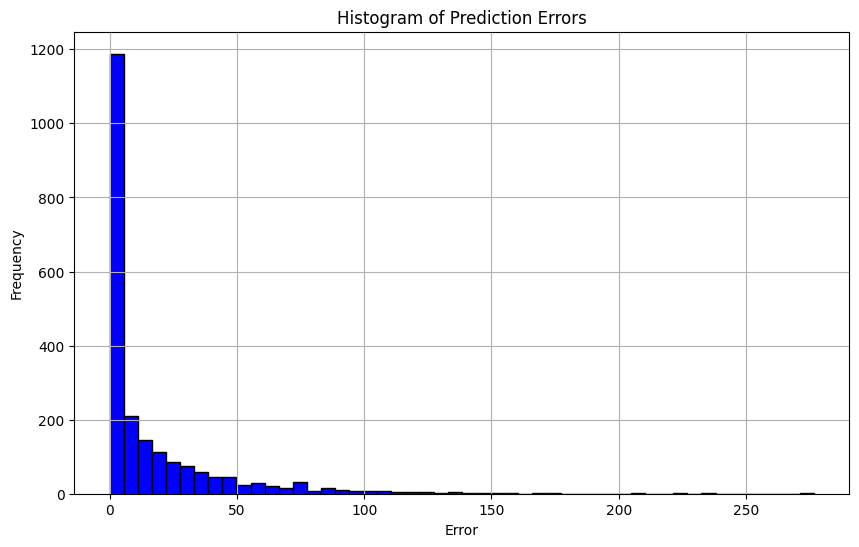

In [38]:
# Histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.grid(True)
plt.show()

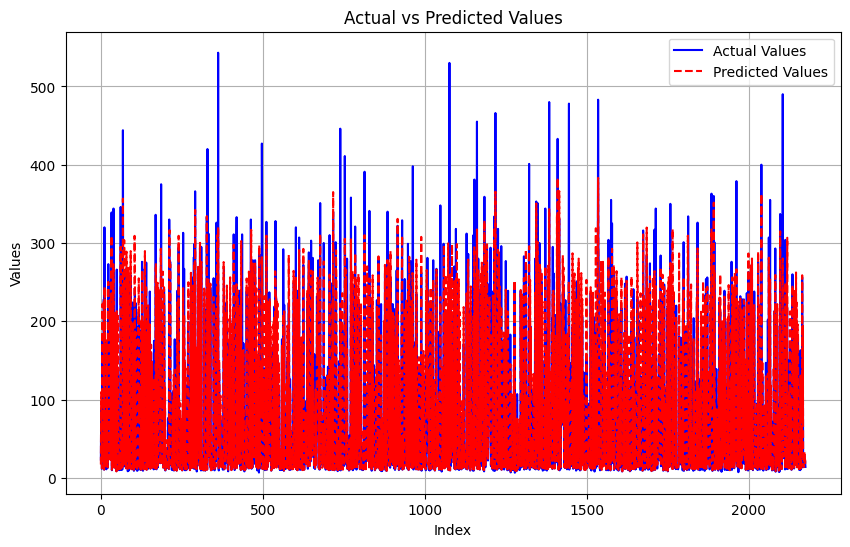

In [39]:
# Line plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(test_labels)), test_labels, color='blue', label='Actual Values')
plt.plot(range(len(predictions)), predictions, color='red', linestyle='--', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [41]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')